# Price stock tendency prediction

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()

In [2]:
from tqdm.notebook import trange, tqdm

from helpers.data_helper import *

In [3]:
DATA_PATH = '../data/'
quotation = 'CMCSA'
FILE_SUFFIX = '.txt'
price_column = 'Close'
PREDICT_N = 1

In [4]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}{FILE_SUFFIX}", compute_features=True, predict_n=PREDICT_N, thresh_diff=0.005, normalize=True)
data_wrapper.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,0.000000,1980-05-02,0.0,0.000000,0.000000,0.000000,0.000000,0.000623,0.329551,0.679060,...,0.000000,0.000000,0.000000,0.583492,0.522988,0.428385,0.380473,stay,0.000000,stay
1,0.000096,1980-05-05,0.0,0.000000,0.000000,0.000000,0.000000,0.000356,0.329551,0.679060,...,0.000011,0.000007,0.000007,0.583447,0.522937,0.428385,0.380473,stay,0.000019,higher
2,0.000193,1980-05-06,0.0,0.000018,0.000019,0.000019,0.000013,0.000623,0.329261,0.711642,...,0.000025,0.000015,0.000016,0.583512,0.522886,0.428526,0.407937,higher,0.000019,stay
3,0.000289,1980-05-07,0.0,0.000018,0.000019,0.000019,0.000013,0.001156,0.329261,0.711642,...,0.000038,0.000024,0.000023,0.583465,0.522835,0.428385,0.380473,stay,0.000074,higher
4,0.000385,1980-05-08,0.0,0.000073,0.000076,0.000074,0.000054,0.001868,0.328393,0.792794,...,0.000057,0.000032,0.000037,0.583735,0.522723,0.428809,0.461954,higher,0.000111,higher


In [5]:
data_wrapper.df.isnull().values.any()

False

### Plots

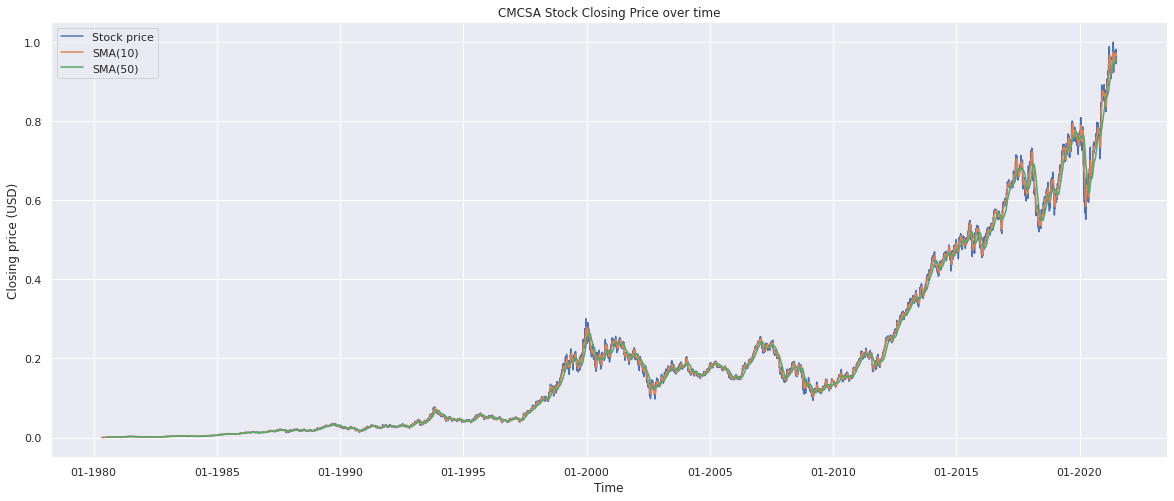

In [6]:
from helpers.plots_helper import plot_prices

ax = plot_prices(data_wrapper['Date'], data_wrapper[price_column], quotation_name=quotation, ma_values=[10,50])

Text(0.5, 1.0, 'Normalized histogram of classes for CMCSA')

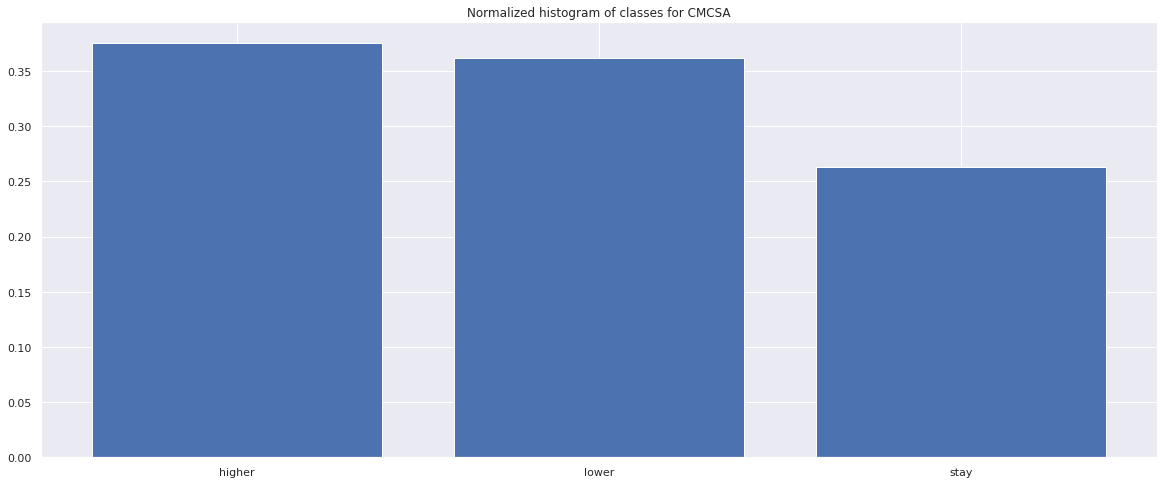

In [7]:
from helpers.plots_helper import *
ax = plot_normalized_histogram(data_wrapper['Next'])
ax.set_title(f"Normalized histogram of classes for {quotation}")

### ML Data preparation

In [8]:
print(data_wrapper.feature_names)

['LowLen', 'RSI(14)', 'GAP', 'RSI_diff', 'Volume_diff', 'MACD', 'MACD_diff', 'MACD_signal', 'BodyLen', 'BG_L_Band', 'BG_H_Band', 'BG_L_Band_Indicator', 'BG_H_Band_Indicator', 'ROC', 'StochOsc', 'SMA(10)', 'SMA(20)', 'EMA(14)', 'EMA_Diff', 'SMA(20) - SMA(10)', 'Difference', 'PercentageDiff', 'Tendency', 'NextPrice', 'Next']


In [9]:
data_columns = ['Close', 'SMA(20)', f"RSI(14)", 'Volume', 'LowLen', 'MACD']
data_columns = ['Volume', 'RSI(14)', 'LowLen', 'Close', 'MACD', 'SMA(20)']
#data_columns = ['Difference', 'Close', 'MACD_diff', 'RSI(14)']
X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.3, 
                                                             y_column='Next', 
                                                             features_list=data_columns)

## Classifier and evaluation

In [10]:
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = True

if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
    # format as dict
    class_weights = {c:w for c,w in zip(np.unique(y_train), class_weights)}

    print(class_weights)
else:
    class_weights = None

{0: 0.8684839789574367, 1: 1.4069339531280263, 2: 0.878886872353297}


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[1 2 1 ... 2 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


### Grid Search

In [20]:
from sklearn.model_selection import TimeSeriesSplit
# build the time series split for cross validation so no data leakage
tscv = TimeSeriesSplit(n_splits=5)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = True

# default parameters
best_params = {'DTree': {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 50}, 'SVM': {'C': 0.5, 'gamma': 'scale', 'kernel': 'poly'}, 'LR': {'C': 0.1, 'fit_intercept': False, 'penalty': 'l2'}}
param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        #'C':[1e-3, 1e-2, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 100.0],
        'C':[0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0],
        'probability':[True, False],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0],
        'fit_intercept':[True, False],
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], cv=tscv.split(X_train), n_jobs=6)
    clf.fit(X_train, y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], cv=tscv.split(X_train), n_jobs=6)
    clf.fit(X_train, y_train)
    best_params['RandomForest'] = clf.best_params_

    
    svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], cv=tscv.split(X_train), n_jobs=6, verbose=30)
    clf.fit(X_train, y_train)
    best_params['SVM'] = clf.best_params_
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], cv=tscv.split(X_train), n_jobs=6)
    clf.fit(X_train, y_train)
    best_params['LR'] = clf.best_params_


    print(best_params)

Performing grid search...
Fitting 5 folds for each of 120 candidates, totalling 600 fits


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


{'DTree': {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 200}, 'SVM': {'C': 200.0, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}, 'LR': {'C': 0.1, 'fit_intercept': True, 'penalty': 'none'}}


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Classifiers

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights, probability=True)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [ ]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

print("Training...")

for clf_label, clf in clf_dict.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    print(f"Training accuracy : {accuracy_score(y_pred, y_train)}")
    
print("Training done.")



[DTree] Accuracy : 0.33, F1 : 0.44
[RandomForest] Accuracy : 0.34, F1 : 0.37
[SVM] Accuracy : 0.34, F1 : 0.44
[LR] Accuracy : 0.30, F1 : 0.43


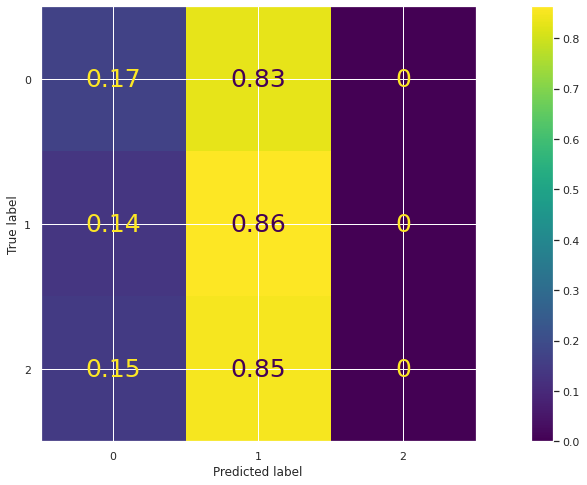

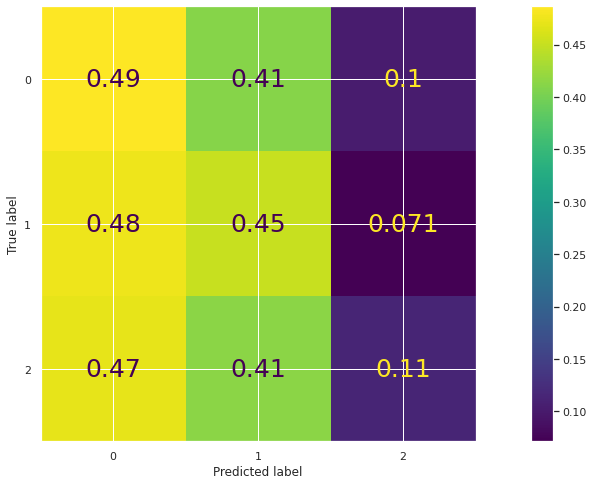

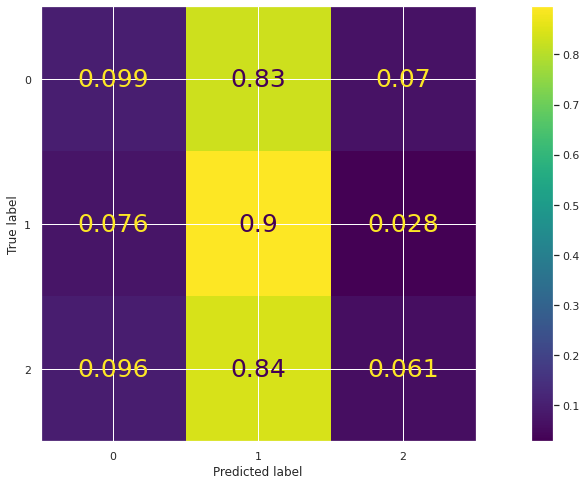

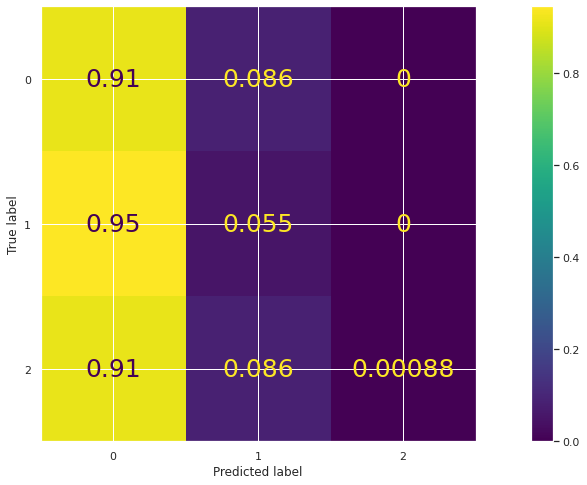

In [15]:
for clf_label, clf in clf_dict.items():
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average='weighted')
    
    print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
    plot_confusion_matrix(clf, X_test, y_test, normalize='true')

[0.23986776 0.         0.         0.10176599 0.08472301 0.57364324]
|--- SMA(20) <= 0.00
|   |--- Volume <= 0.00
|   |   |--- MACD <= 0.58
|   |   |   |--- class: 2
|   |   |--- MACD >  0.58
|   |   |   |--- class: 1
|   |--- Volume >  0.00
|   |   |--- MACD <= 0.58
|   |   |   |--- class: 1
|   |   |--- MACD >  0.58
|   |   |   |--- class: 0
|--- SMA(20) >  0.00
|   |--- Volume <= 0.05
|   |   |--- SMA(20) <= 0.01
|   |   |   |--- class: 1
|   |   |--- SMA(20) >  0.01
|   |   |   |--- class: 0
|   |--- Volume >  0.05
|   |   |--- Close <= 0.15
|   |   |   |--- class: 0
|   |   |--- Close >  0.15
|   |   |   |--- class: 1



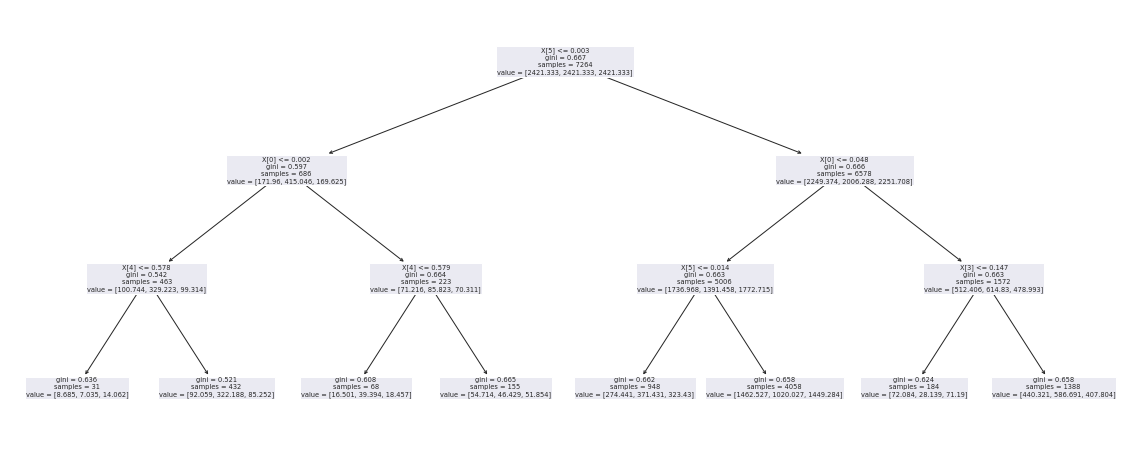

In [16]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(data_columns))

print(rules)

In [17]:
data_wrapper['LowLen'].describe()

count    10378.000000
mean         0.347837
std          0.084521
min          0.000000
25%          0.356189
50%          0.363609
75%          0.381122
max          1.000000
Name: LowLen, dtype: float64

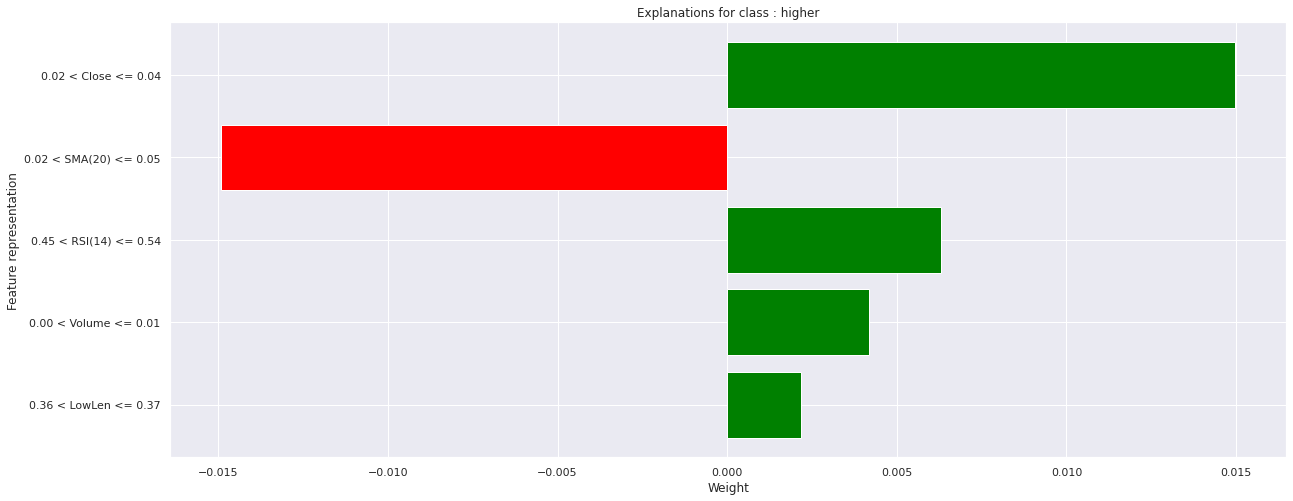

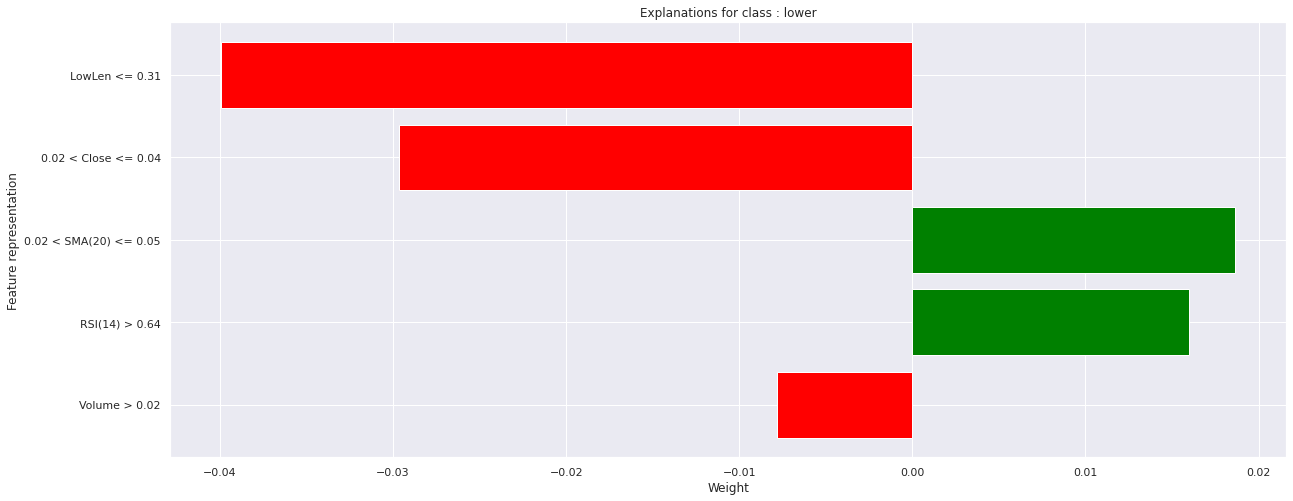

In [18]:
import lime
from lime import lime_tabular, submodular_pick

def explain_clf(predict_func, X_train, y_train, data_columns, class_names, n_exps):
    explainer = lime_tabular.LimeTabularExplainer(X_train, training_labels=y_train,
                                                   discretize_continuous = True,
                                                   feature_names=data_columns, class_names=class_names,                                                
                                                   verbose=False, mode='classification')
    
    sp_obj = submodular_pick.SubmodularPick(explainer, X_train, predict_func, sample_size=n_exps, num_features=5, num_exps_desired=1)
    for exp in sp_obj.explanations:
        label = list(exp.as_map().keys())[0]
        fig = exp.as_pyplot_figure(label=label)
        ax = plt.gca()
        ax.set_ylabel('Feature representation')
        ax.set_xlabel('Weight')
        ax.set_title(f"Explanations for class : {class_names[label]}")
        exp.show_in_notebook(show_table=True)
        
    return exp
        
    """i = 12
    print(clf.predict((X_test[i]).reshape(1, -1)))
    exp = explainer.explain_instance(X_test[i], clf.predict_proba, num_features=5, top_labels=3)
    exp.show_in_notebook(show_table=True)
    print(exp.as_list())
    #pd.DataFrame(exp.as_list())
    
    exp.as_pyplot_figure()
    plt.show()"""

exp = explain_clf(clf_dict['SVM'].predict_proba, X_train, y_train, data_columns, ['lower', 'stay', 'higher'], n_exps=2)



# some code taken from https://stats.stackexchange.com/questions/317231/how-to-extract-global-feature-importances-of-a-black-box-model-from-local-explan
label = list(exp.as_map().keys())[0]
exp_map = exp.as_map()
features_list = exp.as_list(label=label)
print(features_list)
importances = { i: 0.0 for i in range(X_train.shape[1]) }


print(exp_map[label])
print(data_columns)

feat = [exp_map[label][m][0] for m in range(len(exp_map[label]))]
print(feat)
# get all feature weights of class "1"
weight = [exp_map[label][m][label] for m in range(len(exp_map[label]))]

# sum 
for m in range(len(feat)):
    importances[feat[m]] = importances[feat[m]] + weight[m] 

feature_importances = {col:val for col, val in zip(data_columns, importances.values())}
feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}
print(feature_importances)

exp.show_in_notebook(show_table=True)